# nCoV-2019
<img src='https://ars.els-cdn.com/content/image/3-s2.0-B9780443073670000409-f040-001-9780443073670.jpg'>

<b>Overview:</b> <br>
Model the growth of the nCoV-2019 Corona Virus infections in mainland China and outside the mainland.

<b>Data Source:</b> <br>
https://en.m.wikipedia.org/wiki/Timeline_of_the_2019–20_Wuhan_coronavirus_outbreak <br>
http://www.nhc.gov.cn/xcs/yqtb/list_gzbd.shtml <br>
https://www.thelancet.com/pb-assets/Lancet/pdfs/S0140673620302117.pdf <br>
Clinical outcome (99 Cases)
<li> Remained in hospital 57 (58%)
<li> Discharged 31 (31%)
<li> Died 11 (11%)

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 28 08:19:13 2020

"""
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

#import packages
import pandas as pd
import numpy as np
import xlrd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from tabulate import tabulate
from matplotlib import style
from matplotlib.pylab import rcParams
style.use('fivethirtyeight')
#style.use('ggplot')


In [2]:
df_xls=pd.read_excel(r'Corona.xlsx')

#Eliminating sparse data
# df=df_xls[7:]


In [3]:
# df=df.reset_index(drop=True)

In [4]:
# df_xls=df_xls[:22]

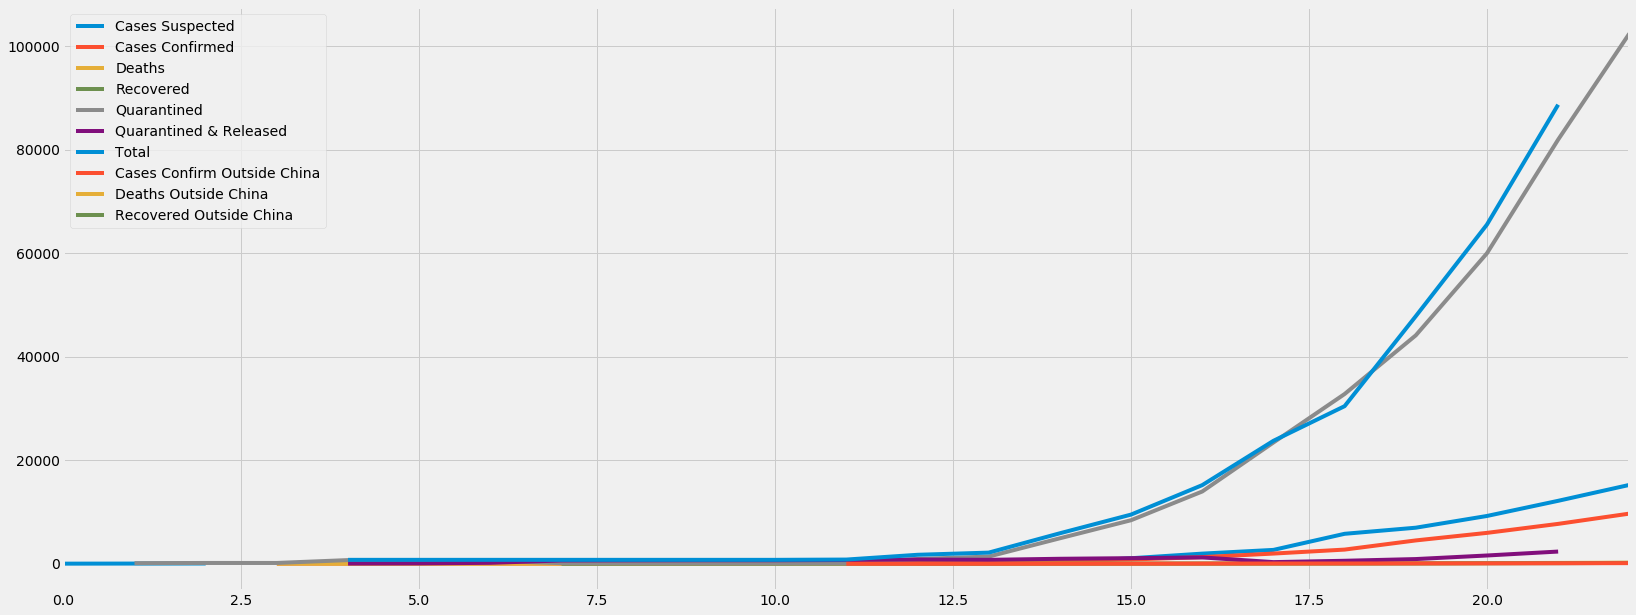

In [5]:
rcParams['figure.figsize'] = 25,10
df_xls.plot()

In [6]:
df=df_xls.fillna(0)
df

,Date,Cases Suspected,Cases Confirmed,Deaths,Recovered,Quarantined,Quarantined & Released,Total,Source,Cases Confirm Outside China,Deaths Outside China,Recovered Outside China
0,2019.12.31,27.0,0.0,0.0,0.0,0.0,0.0,0.0,[3],0.0,0.0,0.0
1,2020.01.03,44.0,0.0,0.0,0.0,121.0,0.0,0.0,[4],0.0,0.0,0.0
2,2020.01.05,59.0,0.0,0.0,0.0,163.0,0.0,0.0,[5],0.0,0.0,0.0
3,2020.01.10,0.0,41.0,1.0,0.0,163.0,0.0,0.0,[6],0.0,0.0,0.0
4,2020.01.11,0.0,41.0,1.0,0.0,717.0,46.0,763.0,[7],0.0,0.0,0.0
5,2020.01.12,0.0,41.0,1.0,0.0,687.0,76.0,763.0,[8],0.0,0.0,0.0
6,2020.01.13,0.0,41.0,1.0,0.0,576.0,187.0,763.0,[9],0.0,0.0,0.0
7,2020.01.15,0.0,41.0,2.0,7.0,119.0,644.0,763.0,[10],0.0,0.0,0.0
8,2020.01.16,0.0,45.0,2.0,12.0,98.0,665.0,763.0,[11],0.0,0.0,0.0
9,2020.01.17,0.0,62.0,2.0,15.0,82.0,681.0,763.0,[12],0.0,0.0,0.0


CONFIRMED CASES in China


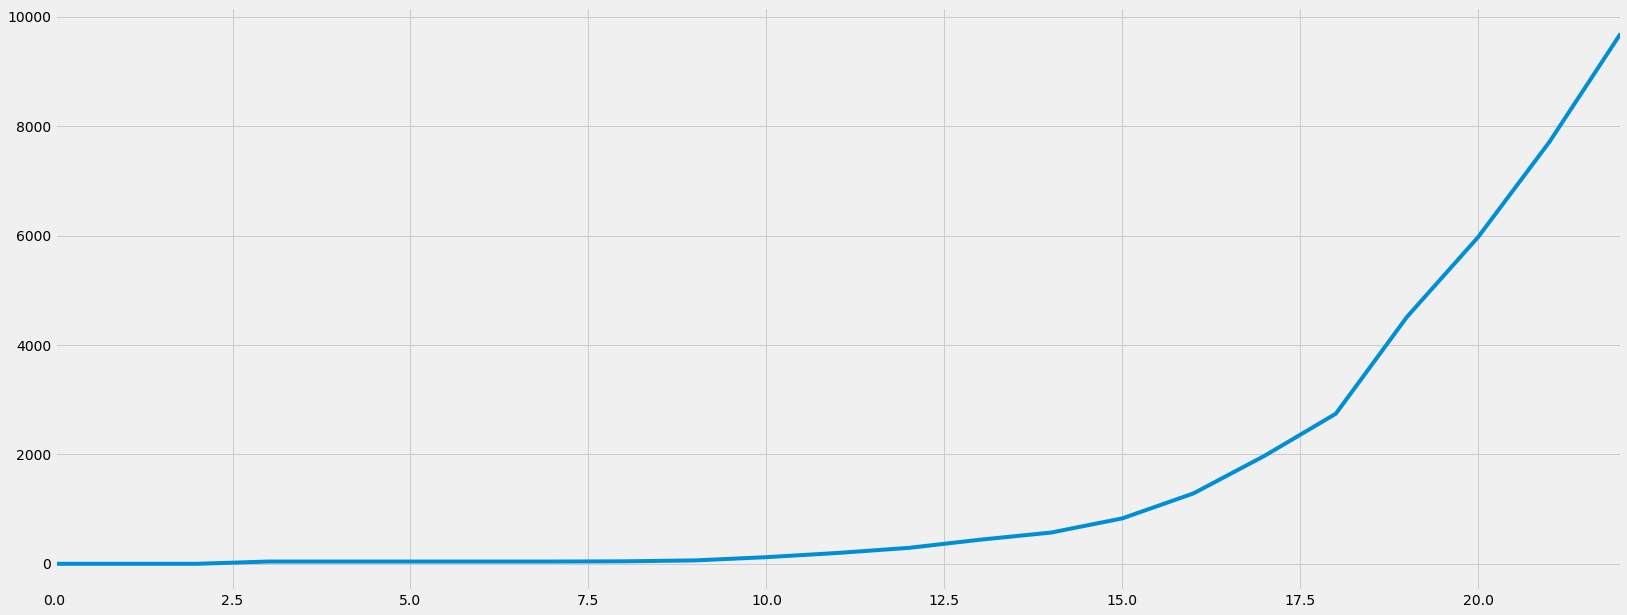

In [7]:
df_sc = df['Cases Suspected']
df_cc = df['Cases Confirmed']
print('CONFIRMED CASES in China')
df_cc.plot()

RECOVERIES vs. FATALITIES


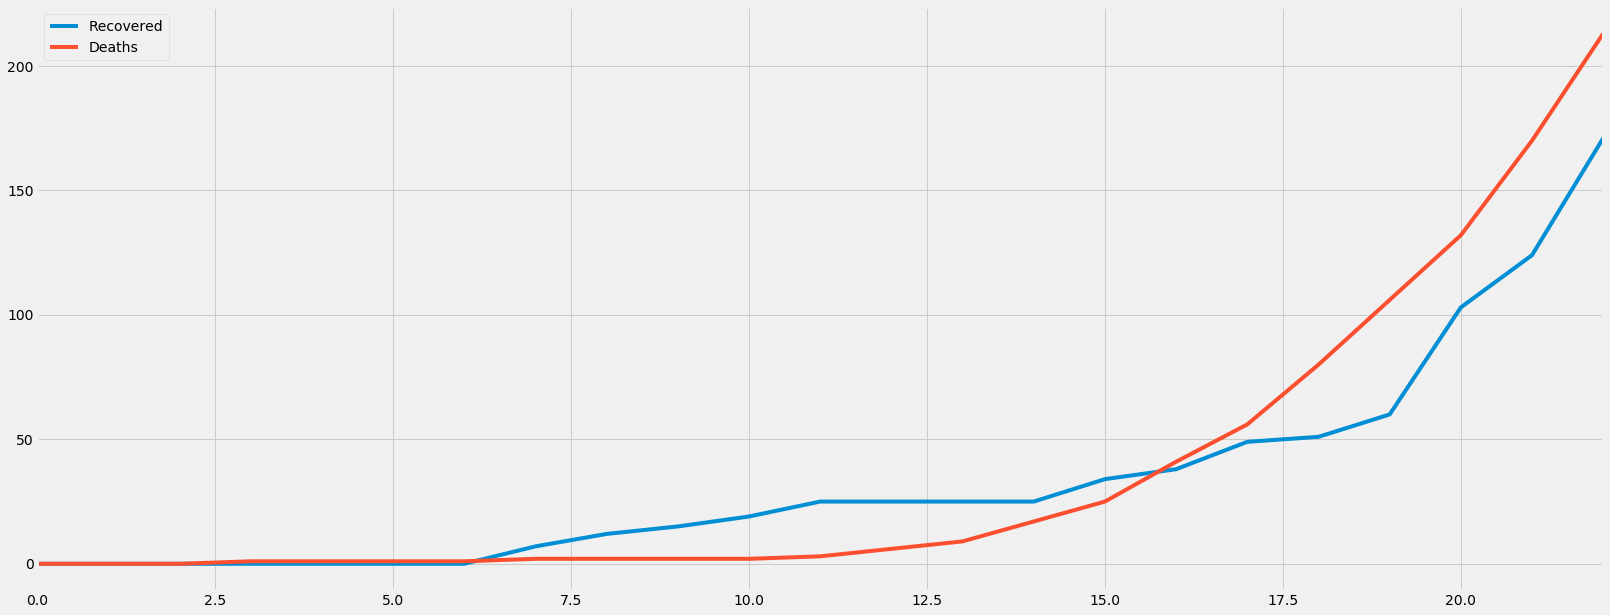

In [8]:
df_d = df['Deaths']
df_r = df['Recovered']
print('RECOVERIES vs. FATALITIES')
df_r.plot()
df_d.plot()
plt.legend()
plt.show()

In [9]:
def exponential_fit(x, a, b, c):
    return a*np.exp(b*x) + c

def linear_fit(x, m, c):
    return (m*x) + c

In [10]:
def proj(dat, no, d=10000000):
    n=no
    data = dat
    y=np.array(dat)
    x=np.array(dat.index)
    
    #Fit Data
    #Dropped the last data point in the fit, and used it as a test for the fit
    fitting_parameters, covariance = curve_fit(exponential_fit, x[:n], y[:n])
    a, b, c = fitting_parameters
    print('a = ',a)
    print('b = ',b)
    print('c = ',c)
    
    print('Next predicted data point {:,.0f}'.format(exponential_fit(n, a, b, c)))
   
    #Plot Curve Fit with Data 
    rcParams['figure.figsize'] = 25,10
    x_min = 0  
    x_max = 60
    y_min = -100
    y_max = d
    x_fit = np.linspace(x_min, x_max, 100)   
    plt.plot(x, y, 'o', markersize = 15, label = 'Actuals')
    plt.plot(x_fit, exponential_fit(x_fit, *fitting_parameters), '--', label='Fit')

    plt.axis([x_min, x_max, y_min, y_max])
    plt.legend()
    plt.show()

suspected CASES
***************
a =  23.580485305763933
b =  0.297257856446865
c =  -338.43213895631135
Next predicted data point 21,630


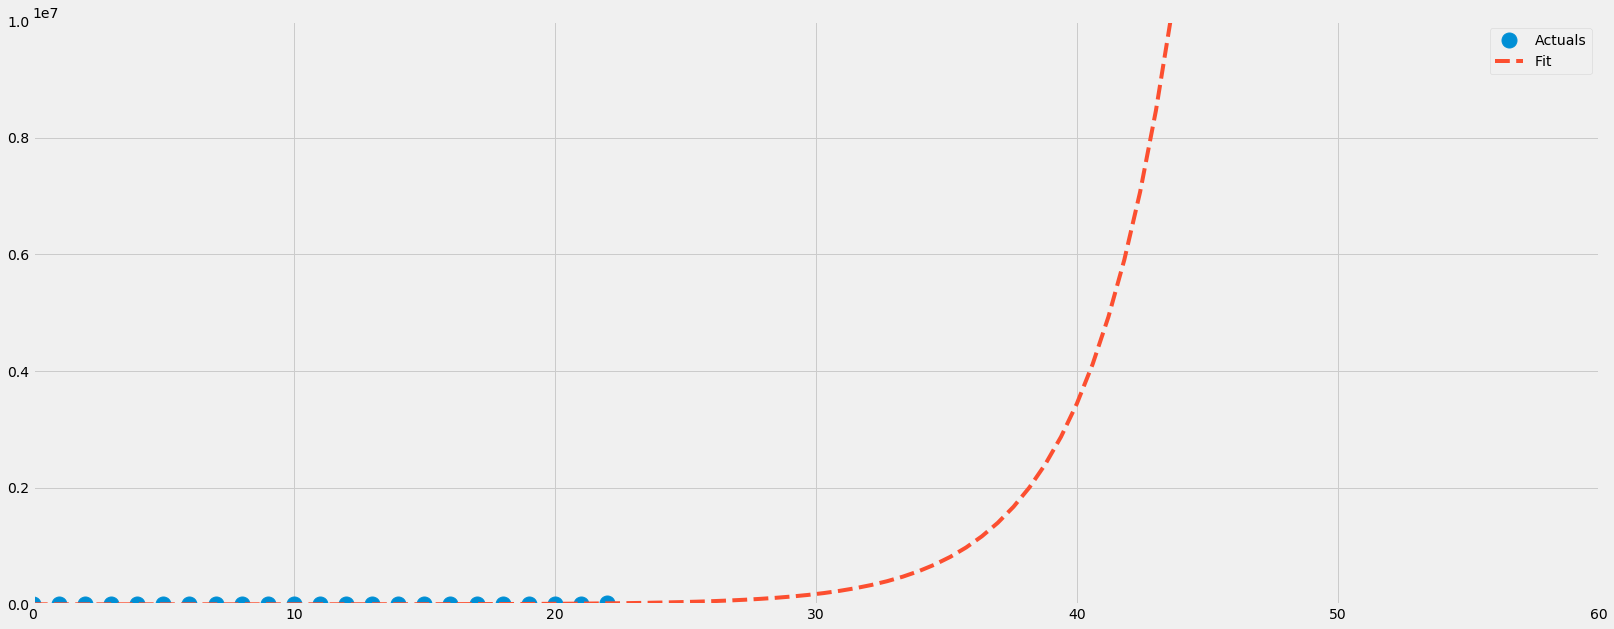

In [11]:
# test_data = 1
points = 0
length = df_sc.count()
n = length - points
print('suspected CASES')
print('***************')
proj(df_sc,n)

suspected CASES
***************
a =  23.580485305763933
b =  0.297257856446865
c =  -338.43213895631135
Next predicted data point 21,630


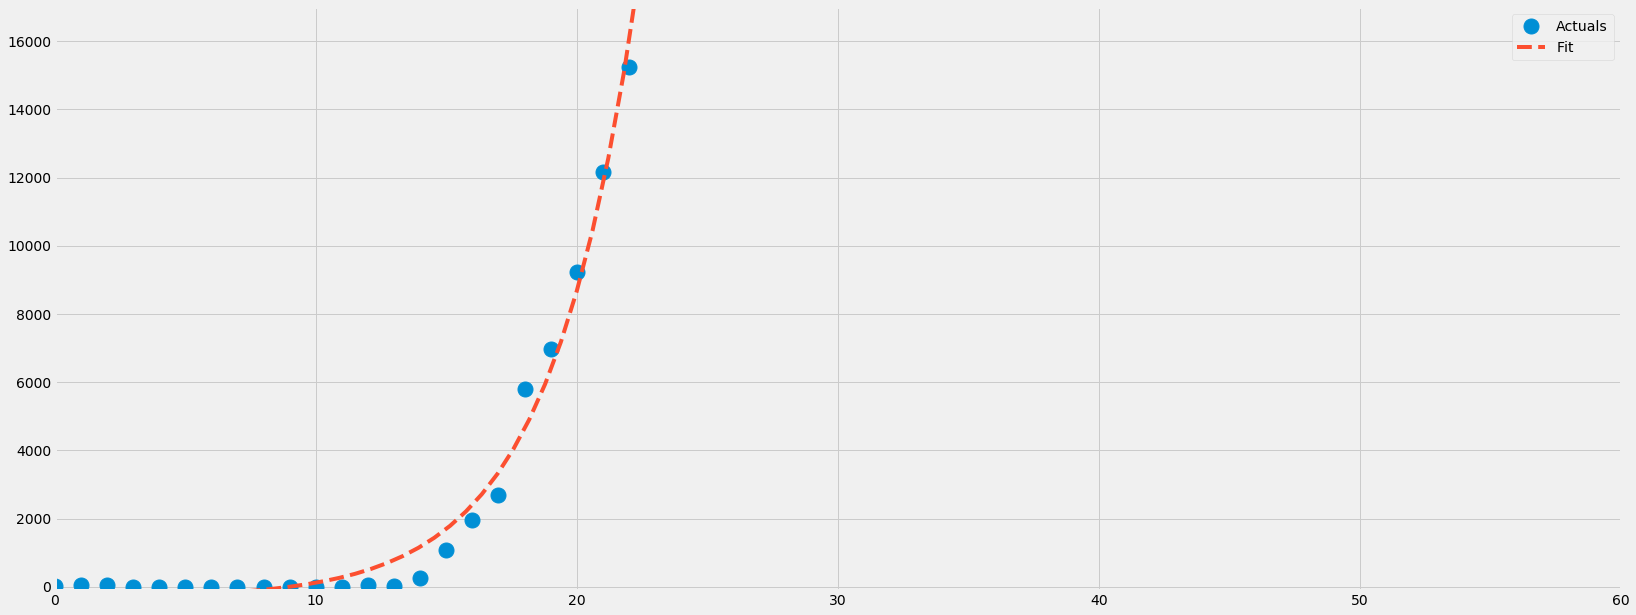

In [12]:
# test_data = 1
points = 0
length = df_sc.count()
n = length - points
print('suspected CASES')
print('***************')
proj(df_sc,n,17000)

CONFIRMED CASES
***************
a =  13.947664084774106
b =  0.29989800476416617
c =  -120.89274849890462
Next predicted data point 13,687


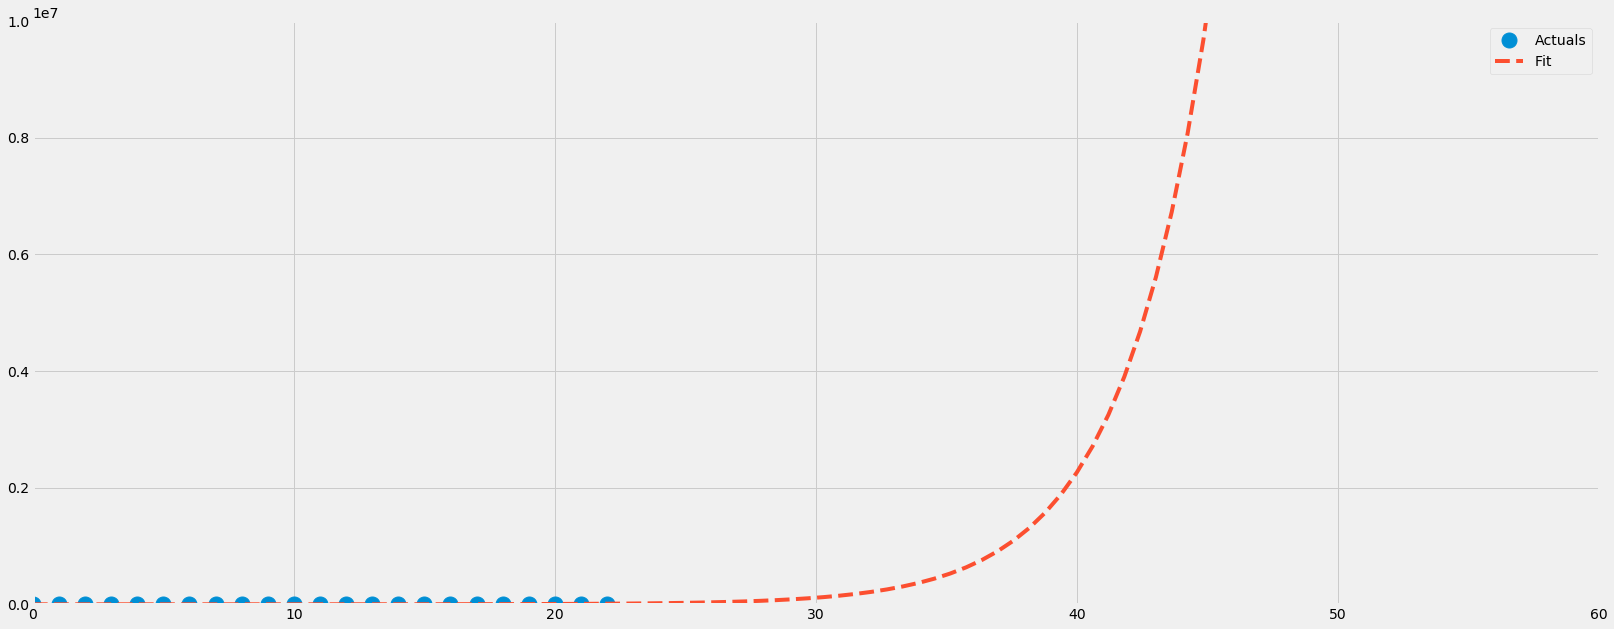

In [13]:
# test_data = 1
points = 0
length = df_cc.count()
n = length - points
print('CONFIRMED CASES')
print('***************')
proj(df_cc,n)

a =  13.947664084774106
b =  0.29989800476416617
c =  -120.89274849890462
Next predicted data point 13,687


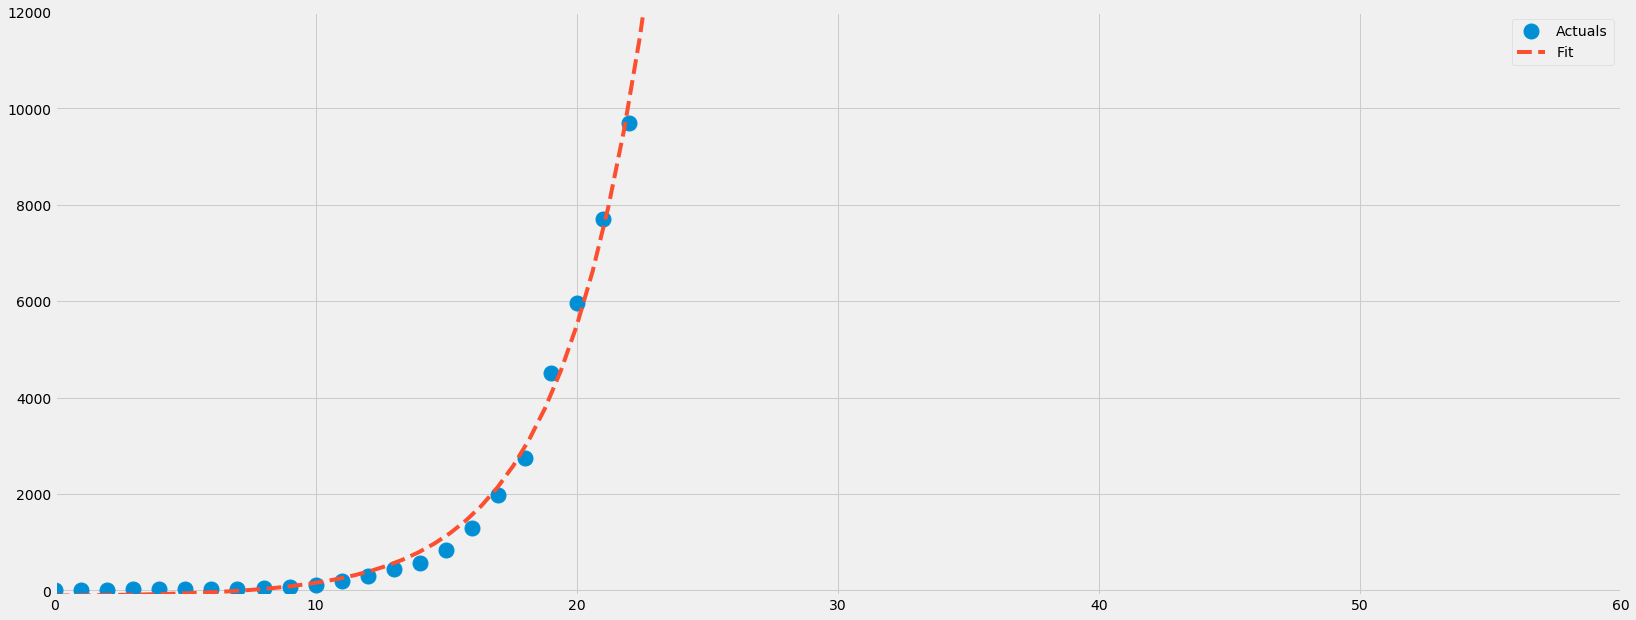

In [14]:
#Zoom-in
proj(df_cc,n,12000)

CONFIRMED CASES outside Mainland China
**************************************


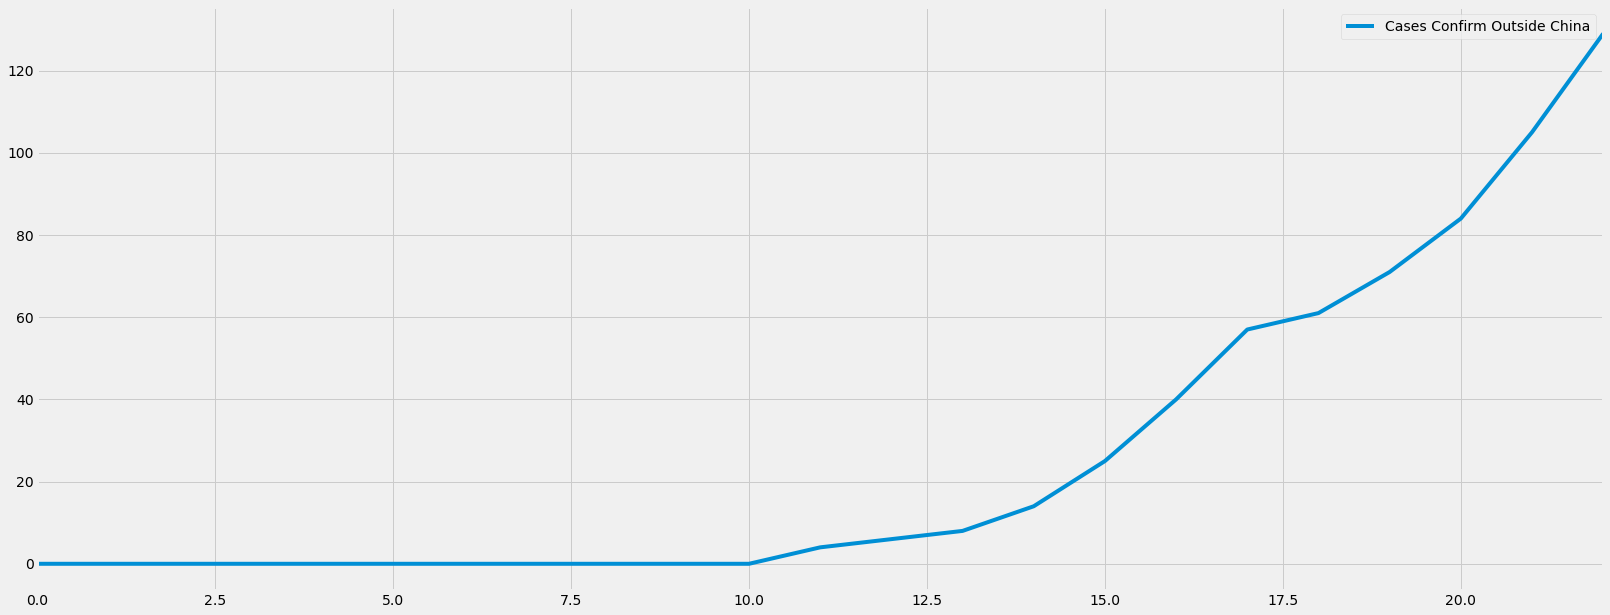

In [15]:
df_cco = df['Cases Confirm Outside China']
print('CONFIRMED CASES outside Mainland China')
print('**************************************')
df_cco.plot()
plt.legend()
plt.show()

In [16]:
df_cco=df_cco.fillna(0)

CONFIRMED CASES outside Mainland China - Exponential Model
**********************************************************
a =  1.5424474304590512
b =  0.20419021794218895
c =  -5.8743468380223325
Next predicted data point 163


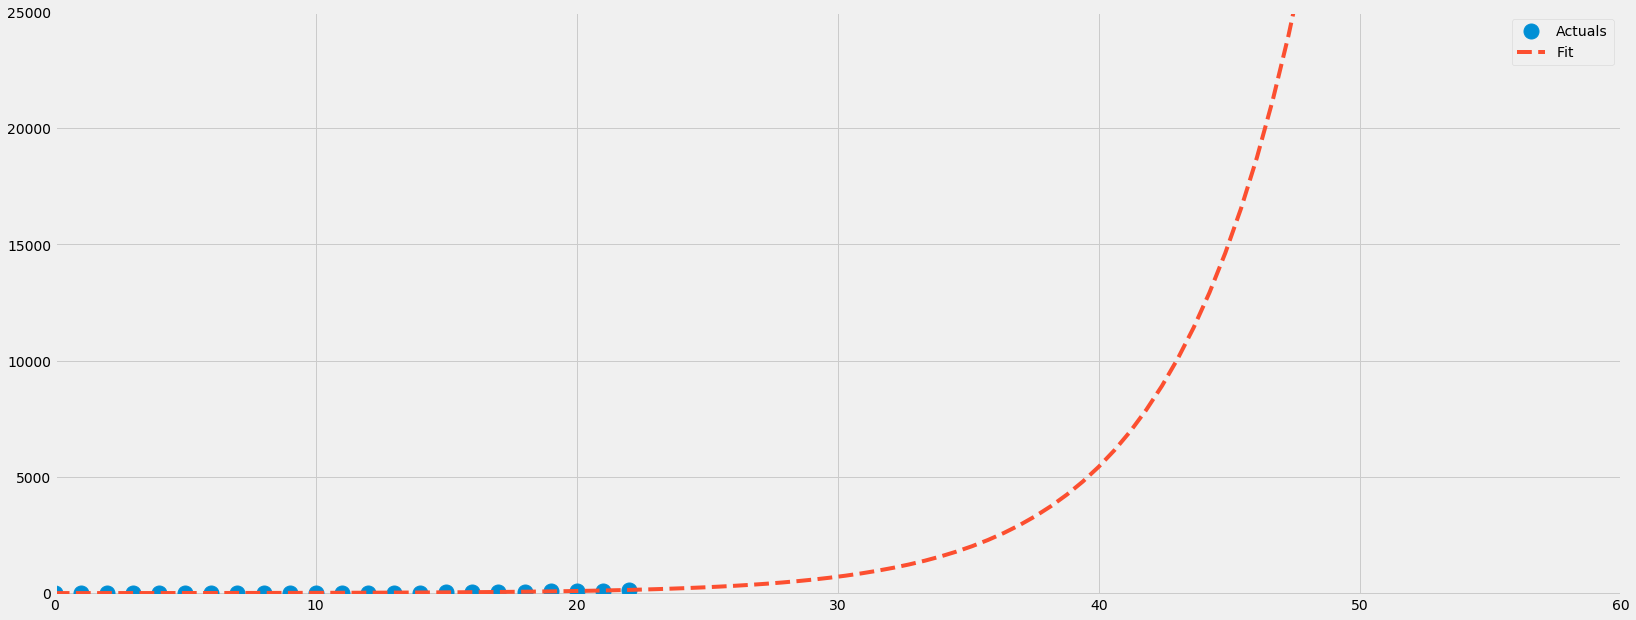

In [17]:
# test_data = 1
points = 0
length = df_cco.count()
n = length - points
print('CONFIRMED CASES outside Mainland China - Exponential Model')
print('**********************************************************')
proj(df_cco,n,25000)

a =  1.5424474304590512
b =  0.20419021794218895
c =  -5.8743468380223325
Next predicted data point 163


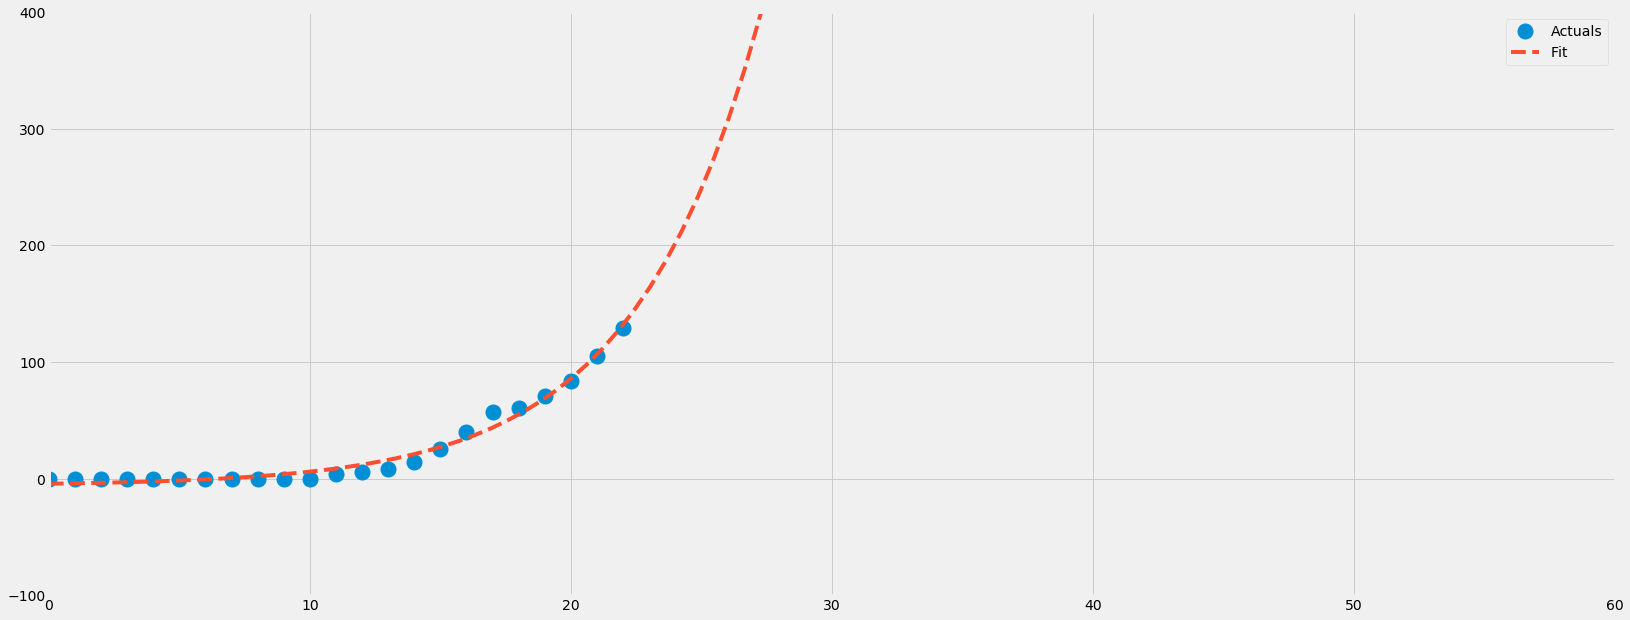

In [18]:
#Zoom-in
proj(df_cco,n,400)

In [19]:
def proj_lin(dat, no, d=5000):
    n=no
    data = dat
    y=np.array(dat)
    x=np.array(dat.index)
    #Fit Data
    #Dropped the last data point in the fit, and used it as a test for the fit
    fitting_parameters, covariance = curve_fit(linear_fit, x[:n], y[:n])
    m, c = fitting_parameters
    print('m = ',m)
    print('c = ',c)
    print('Next predicted data point {:,.0f}'.format(linear_fit(n+1, m, c)))
    
    #Plot Curve Fit with Data 
    rcParams['figure.figsize'] = 25,10
    x_min = 0  
    x_max = 60
    y_min = -100
    y_max = d
    x_fit = np.linspace(x_min, x_max, 100)   
    plt.plot(x, y, 'o', markersize = 15, label = 'Actuals')
    plt.plot(x_fit, linear_fit(x_fit, *fitting_parameters), '--', label='Fit')

    plt.axis([x_min, x_max, y_min, y_max])
    plt.legend()
    plt.show()
    

CONFIRMED CASES outside Mainland China - LinearModel
****************************************************
m =  4.86758893281476
c =  -27.28260869571388
Next predicted data point 90


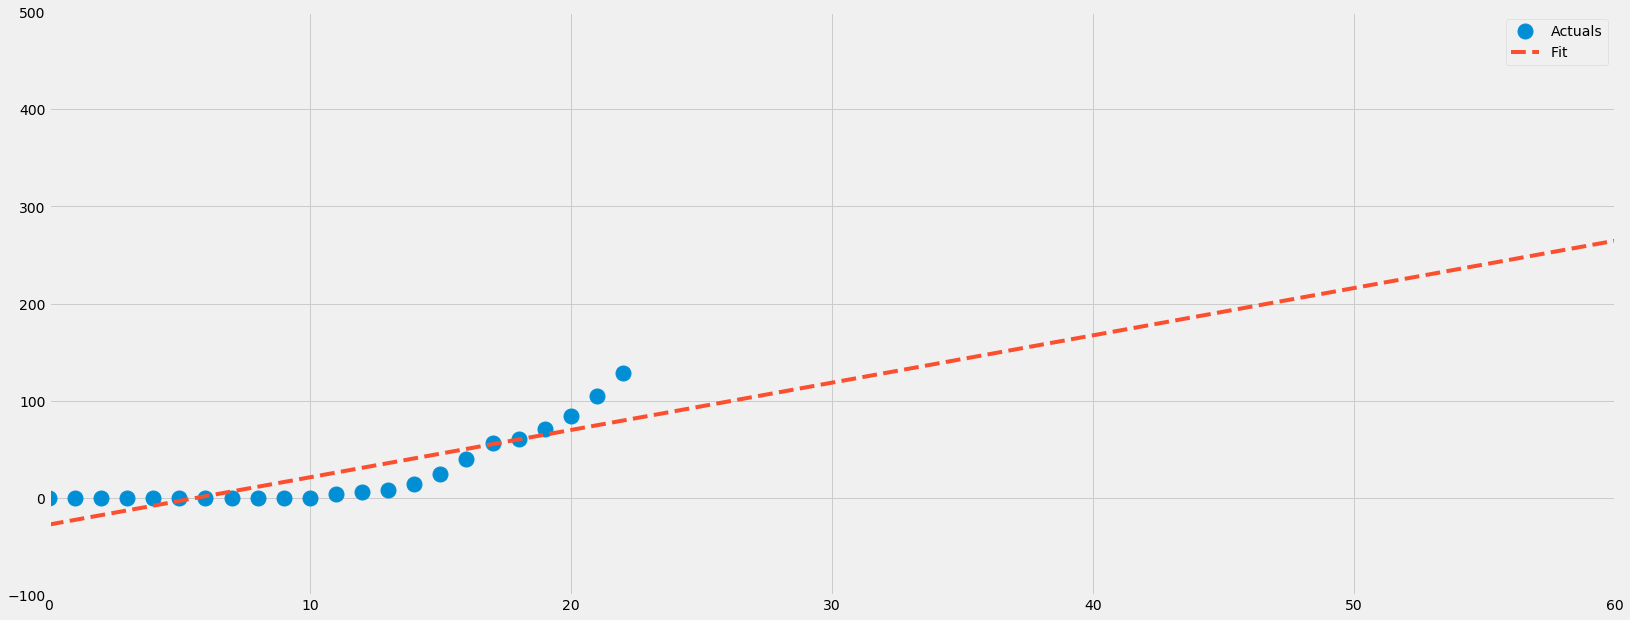

In [20]:
# test_data = 1
points = 0
length = df_cco.count()
n = length - points
print('CONFIRMED CASES outside Mainland China - LinearModel')
print('****************************************************')
proj_lin(df_cco,n,500)

NOTE: Exponential Model is better fit than the Linear Model

FATALITIES
**********
a =  0.6750750641346028
b =  0.2638009256346252
c =  -4.038403644370087
Next predicted data point 287


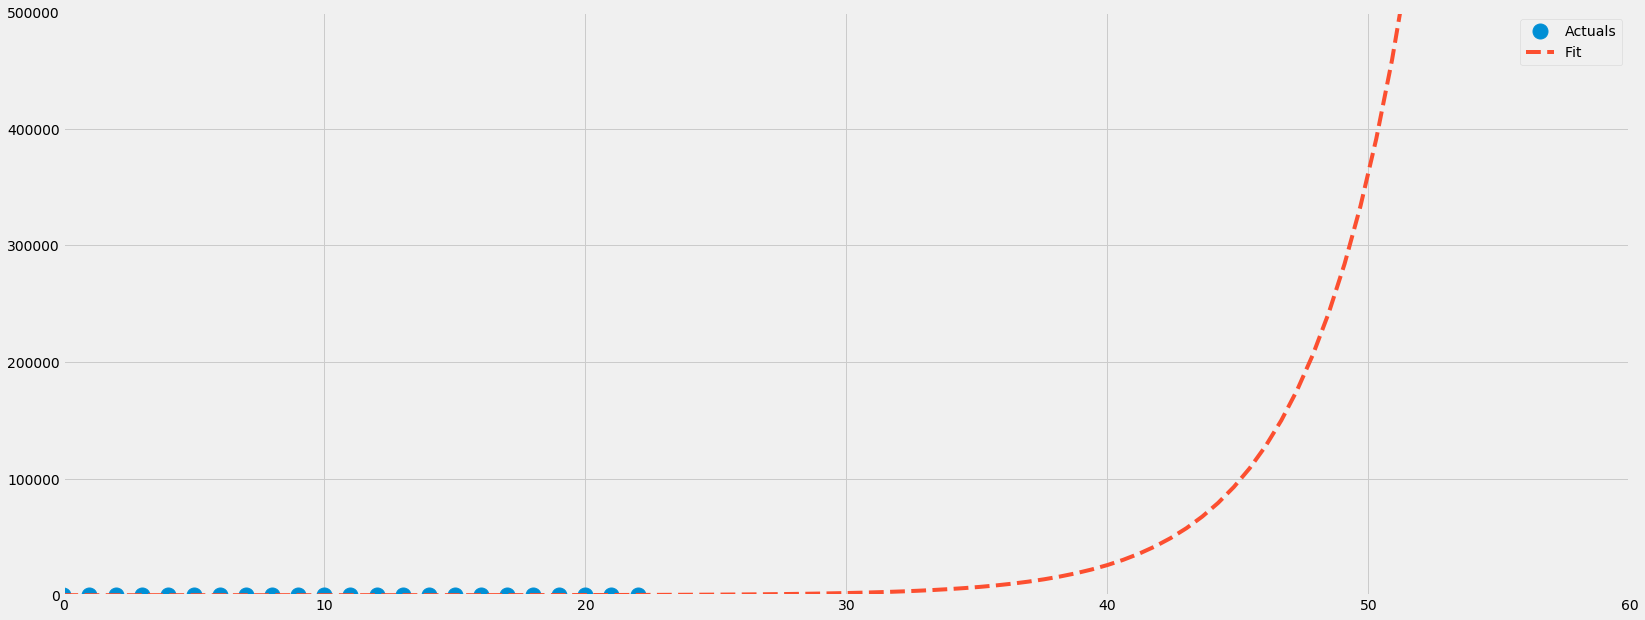

In [21]:
# test_data = 1
points = 0
length = df_d.count()
print('FATALITIES')
print('**********')
n = length - points
proj(df_d,n, 500000)

a =  0.6750750641346028
b =  0.2638009256346252
c =  -4.038403644370087
Next predicted data point 287


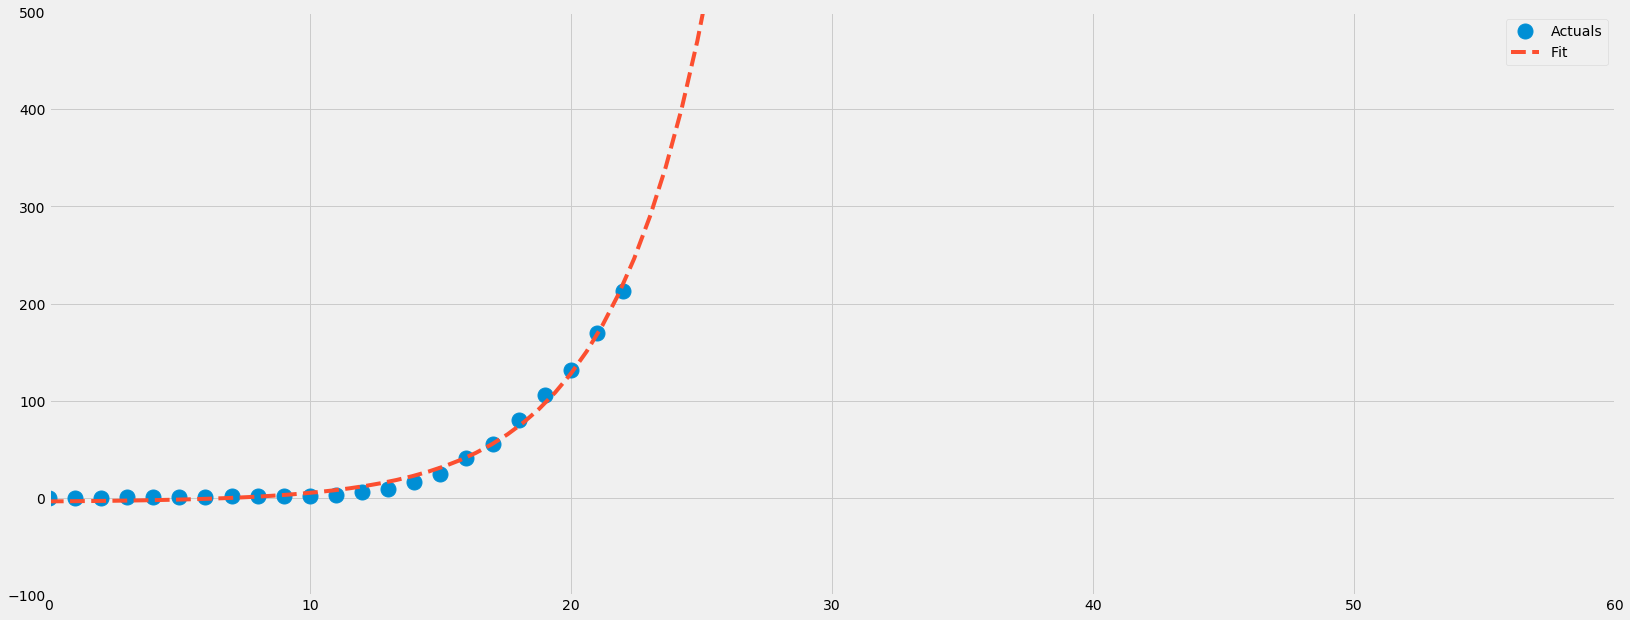

In [22]:
#Zoom-in
proj(df_d,n, 500)

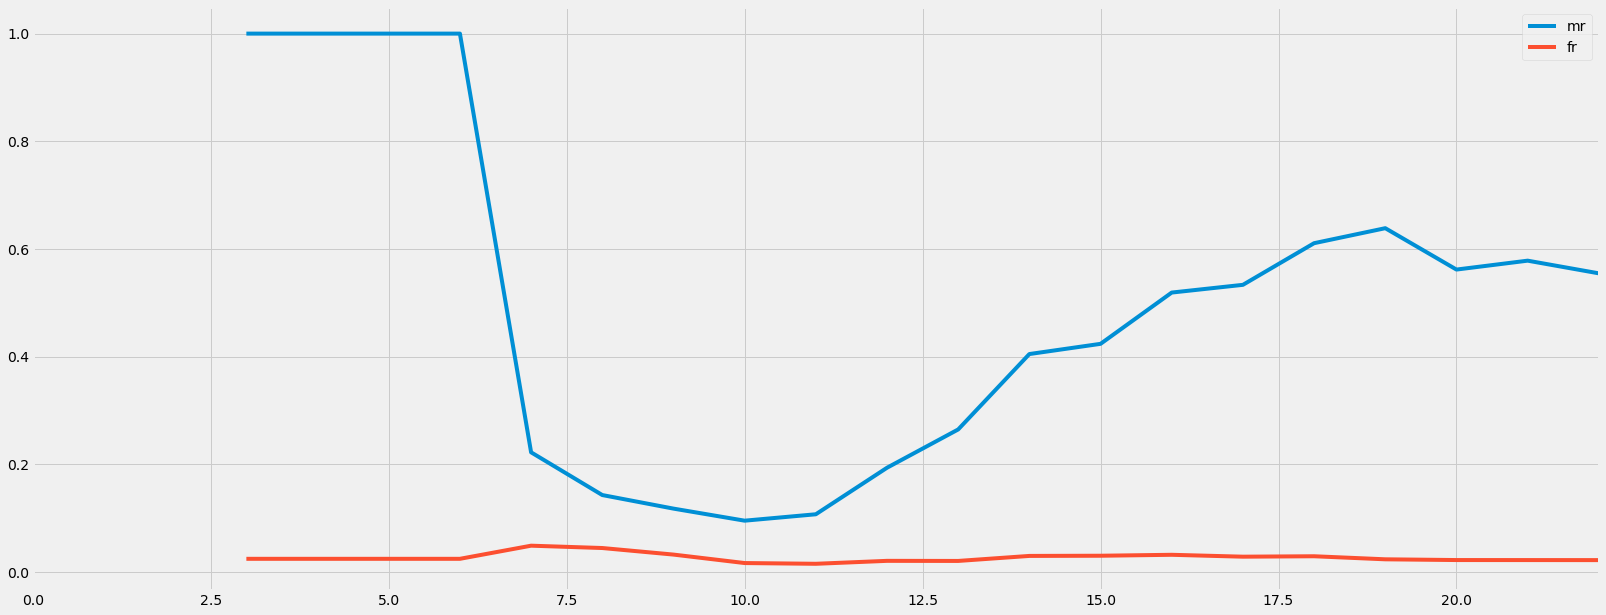

In [23]:
# MR % = Fatalities / (Fatalities + Recovered)

df['mr'] = df.Deaths/(df.Deaths + df.Recovered)
print()
df.mr.plot()


# FR % = Fatalities / Confirmed Cases

df['fr'] = df.Deaths/(df['Cases Confirmed'])
df.fr.plot()
plt.legend()

plt.show()

Current:  F.R. =  2.20%
          M.R. = 55.47%
Reference [RED Dot] from Lancet Study 11.11%


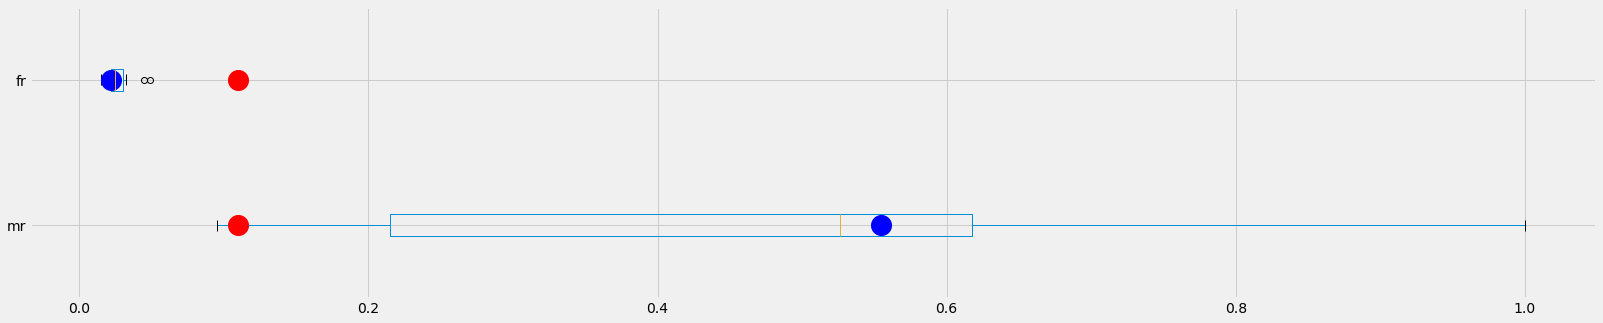

In [24]:
#Boxplots

b=df.fr[len(df)-1]
print('Current:  F.R. =  {:.2%}'.format(b))
a=df.mr[len(df)-1]
print('          M.R. = {:.2%}'.format(a))
print('Reference [RED Dot] from Lancet Study {:.2%}'.format(11/99))

rcParams['figure.figsize'] = 25,5
df.boxplot(column=['mr','fr'], vert = False)
plt.plot(a, [1], marker='o', markersize=20, color="blue")
plt.plot(b, [2], marker='o', markersize=20, color="blue")
plt.plot(.11, [1], marker='o', markersize=20, color="Red")
plt.plot(.11, [2], marker='o', markersize=20, color="Red")
plt.show()

Reference Rates: https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates

<b>Tableau Charts</b><br>
Tableau Charts and Forecasts built using Tableau are available on the URL:<br>
https://public.tableau.com/profile/sm.tx#!/vizhome/nCov19-v2/CasesnFatalitiesDailyDelta <br>
The built-in forecasting algorithms in Tableau Public are fairly simple and less accurate than SciPy. 